In [1]:
import functools
import e3x
from flax import linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
jax.devices()

[cuda(id=0)]

# Moment of inertia tensor

In [2]:
def calculate_moment_of_inertia_tensor(masses, positions):
  diag = jnp.sum(positions**2, axis=-1)[..., None, None]*jnp.eye(3)
  outer = positions[..., None, :] * positions[..., :, None]
  return jnp.sum(masses[..., None, None] * (diag - outer), axis=-3)

def generate_datasets(key, num_train=1000, num_valid=100, num_points=10, min_mass=0.0, max_mass=1.0, stdev=1.0):
  # Generate random keys.
  train_position_key, train_masses_key, valid_position_key, valid_masses_key = jax.random.split(key, num=4)

  # Draw random point masses with random positions.
  train_positions = stdev * jax.random.normal(train_position_key,  shape=(num_train, num_points, 3))
  train_masses = jax.random.uniform(train_masses_key, shape=(num_train, num_points), minval=min_mass, maxval=max_mass)
  valid_positions = stdev * jax.random.normal(valid_position_key,  shape=(num_valid, num_points, 3))
  valid_masses = jax.random.uniform(valid_masses_key, shape=(num_valid, num_points), minval=min_mass, maxval=max_mass)

  # Calculate moment of inertia tensors.
  train_inertia_tensor = calculate_moment_of_inertia_tensor(train_masses, train_positions)
  valid_inertia_tensor = calculate_moment_of_inertia_tensor(valid_masses, valid_positions)

  # Return final train and validation datasets.
  train_data = dict(positions=train_positions, masses=train_masses, inertia_tensor=train_inertia_tensor)
  valid_data = dict(positions=valid_positions, masses=valid_masses, inertia_tensor=valid_inertia_tensor)
  return train_data, valid_data

In [3]:
class Model(nn.Module):
  features = 8
  max_degree = 1

  @nn.compact
  def __call__(self, masses, positions):  # Shapes (..., N) and (..., N, 3).
    # 1. Initialize features.
    x = jnp.concatenate((masses[..., None], positions), axis=-1) # Shape (..., N, 4).
    x = x[..., None, :, None]  # Shape (..., N, 1, 4, 1).

    # 2. Apply transformations.
    x = e3x.nn.Dense(features=self.features)(x)  # Shape (..., N, 1, 4, features).
    x = e3x.nn.TensorDense(max_degree=self.max_degree)(x)  # Shape (..., N, 2, (max_degree+1)**2, features).
    x = e3x.nn.TensorDense(  # Shape (..., N, 2, 9, 1).
        features=1,
        max_degree=2,
    )(x)
    # Try it: Zero-out irrep of degree 1 to only produce symmetric output tensors.
    # x = x.at[..., :, 1:4, :].set(0)

    # 3. Collect even irreps from feature channel 0 and sum over contributions from individual points.
    x = jnp.sum(x[..., 0, :, 0], axis=-2)  # Shape (..., (max_degree+1)**2).

    # 4. Convert output irreps to 3x3 matrix and return.
    cg = e3x.so3.clebsch_gordan(max_degree1=1, max_degree2=1, max_degree3=2)  # Shape (4, 4, 9).
    y = jnp.einsum('...l,nml->...nm', x, cg[1:, 1:, :])  # Shape (..., 3, 3).
    return y

In [4]:
def mean_squared_loss(prediction, target):
  return jnp.mean(optax.l2_loss(prediction, target))

In [5]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update'))
def train_step(model_apply, optimizer_update, batch, opt_state, params):
  def loss_fn(params):
    inertia_tensor = model_apply(params, batch['masses'], batch['positions'])
    loss = mean_squared_loss(inertia_tensor, batch['inertia_tensor'])
    return loss
  loss, grad = jax.value_and_grad(loss_fn)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

@functools.partial(jax.jit, static_argnames=('model_apply',))
def eval_step(model_apply, batch, params):
  inertia_tensor = model_apply(params, batch['masses'], batch['positions'])
  loss = mean_squared_loss(inertia_tensor, batch['inertia_tensor'])
  return loss

def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  params = model.init(init_key, train_data['masses'][0:1], train_data['positions'][0:1])
  opt_state = optimizer.init(params)

  # Determine the number of training steps per epoch.
  train_size = len(train_data['masses'])
  steps_per_epoch = train_size//batch_size

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Draw random permutations for fetching batches from the train data.
    key, shuffle_key = jax.random.split(key)
    perms = jax.random.permutation(shuffle_key, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
    perms = perms.reshape((steps_per_epoch, batch_size))

    # Loop over all batches.
    train_loss = 0.0  # For keeping a running average of the loss.
    for i, perm in enumerate(perms):
      batch = {k: v[perm, ...] for k, v in train_data.items()}
      params, opt_state, loss = train_step(
          model_apply=model.apply,
          optimizer_update=optimizer.update,
          batch=batch,
          opt_state=opt_state,
          params=params
      )
      train_loss += (loss - train_loss)/(i+1)

    # Evaluate on the test set after each training epoch.
    valid_loss = eval_step(
        model_apply=model.apply,
        batch=valid_data,
        params=params
    )

    # Print progress.
    print(f"epoch {epoch : 4d} train loss {train_loss : 8.6f} valid loss {valid_loss : 8.6f}")

  # Return final model parameters.
  return params

In [6]:
# Initialize PRNGKey for random number generation.
key = jax.random.PRNGKey(0)

# Generate train and test datasets.
key, data_key = jax.random.split(key)
train_data, valid_data = generate_datasets(data_key)

# Define training hyperparameters.
learning_rate = 0.002
num_epochs = 100
batch_size = 32

In [7]:
'''print(train_data['masses'][0:1].shape)
print(train_data['positions'][0:1].shape)'''

"print(train_data['masses'][0:1].shape)\nprint(train_data['positions'][0:1].shape)"

In [8]:
'''key, train_key = jax.random.split(key)
model = Model()
params = train_model(
  key=train_key,
  model=model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=num_epochs,
  learning_rate=learning_rate,
  batch_size=batch_size,
)'''

'key, train_key = jax.random.split(key)\nmodel = Model()\nparams = train_model(\n  key=train_key,\n  model=model,\n  train_data=train_data,\n  valid_data=valid_data,\n  num_epochs=num_epochs,\n  learning_rate=learning_rate,\n  batch_size=batch_size,\n)'

In [9]:
'''i = 0
masses, positions, target = valid_data['masses'][i], valid_data['positions'][i], valid_data['inertia_tensor'][i]
prediction = model.apply(params, masses, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))'''

"i = 0\nmasses, positions, target = valid_data['masses'][i], valid_data['positions'][i], valid_data['inertia_tensor'][i]\nprediction = model.apply(params, masses, positions)\n\nprint('target')\nprint(target)\nprint('prediction')\nprint(prediction)\nprint('mean squared error', jnp.mean((prediction-target)**2))"

# Dataset 

In [10]:
filename = "test_data.npz"
dataset= np.load(filename)
for key in dataset.keys():
    print(key)
print('Dipole moment shape array',dataset['D'].shape)
print('Dipole moment units', dataset['D_units'])

print('Atomic numbers', dataset['z'])

type
R
R_units
z
E
E_units
F
F_units
D
D_units
Q
name
README
theory
Dipole moment shape array (5042, 3)
Dipole moment units eAng
Atomic numbers [23 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14]


# Dipole Moment

In [11]:
def prepare_datasets(filename, key, num_train, num_valid):
    # Load the dataset.
    dataset = np.load(filename)
    num_data = len(dataset["E"])

    Z = jnp.full(1, 23)
    Z = jnp.append(Z, jnp.full(16, 14))
    Z=jnp.expand_dims(Z,axis=0)
    Z=jnp.repeat(Z, num_data, axis=0)
    num_draw = num_train + num_valid
    if num_draw > num_data:
        raise RuntimeError(
            f"datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}"
        )

    # Randomly draw train and validation sets from dataset.
    choice = np.asarray(
        jax.random.choice(key, num_data, shape=(num_draw,), replace=False)
    )
    train_choice = choice[:num_train]
    valid_choice = choice[num_train:]

    # Collect and return train and validation sets.
    train_data = dict(
        #energy=jnp.asarray(dataset["E"][train_choice, 0] - mean_energy),
        #forces=jnp.asarray(dataset["F"][train_choice]),
        dipole_moment= jnp.asarray(dataset["D"][train_choice]),
        atomic_numbers=jnp.asarray(Z[train_choice]),
        # atomic_numbers=jnp.asarray(z_hack),
        positions=jnp.asarray(dataset["R"][train_choice]),
    )
    valid_data = dict(
        #energy=jnp.asarray(dataset["E"][valid_choice, 0] - mean_energy),
        #forces=jnp.asarray(dataset["F"][valid_choice]),
        atomic_numbers=jnp.asarray(Z[valid_choice]),
        dipole_moment= jnp.asarray(dataset["D"][valid_choice]),
        # atomic_numbers=jnp.asarray(z_hack),
        positions=jnp.asarray(dataset["R"][valid_choice]),
    )
    return train_data, valid_data

In [12]:
key = jax.random.PRNGKey(0)
num_train=3000
num_val=2000
train_data,valid_data=prepare_datasets(filename,key, num_train,num_val)
print(train_data['dipole_moment'].shape)

(3000, 3)


In [13]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self, atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        """dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(17)
        print('dst_idx',dst_idx.shape)
        dst_idx = jnp.expand_dims(dst_idx, axis=0)
        src_idx = jnp.expand_dims(src_idx, axis=0)
        dst_idx = jnp.repeat(dst_idx, positions.shape[0], axis=0)
        src_idx = jnp.repeat(src_idx, positions.shape[0], axis=0)
        print('dst_idx after expansion',dst_idx.shape)
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst
        print('positions',positions.shape)
        print('displacements',displacements.shape)
        #x = e3x.nn.Embed(num_embeddings=self.max_atomic_number + 1, features=self.features)(atomic_numbers)
        Z= e3x.nn.Embed(num_embeddings=23, features=272)(atomic_numbers)
        print('atomic_numbers',atomic_numbers.shape)
        print('Z',Z.shape)
        Z=Z[0,...]
        Z=jnp.reshape(Z, (272, 17, 1))
        print('Z',Z.shape)
        x = jnp.concatenate((Z, displacements), axis=-1)"""

        positions -= positions[0, ...]

        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        # print("Initial shape:", x.shape)
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).
        # print("x shape:", x.shape)
        # 2. Apply transformations.
        x = e3x.nn.Dense(features=32)(x)
        # print("After Dense layer:", x.shape)
        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        # print("After TensorDense layer:", x.shape)
        # x = e3x.nn.Dense(features=16)(x)
        # x = e3x.nn.Dense(features=1)(x)
        x = jnp.sum(x, axis=-4)
        # print("After sum:", x.shape)
        # x=jnp.sum(x, axis=0)
        # print("After second sum:", x.shape)
        y = x[..., 1, 1:4, 0]
        # y = x[1, 1:4, 0]
        # y=y[None,...]
        # print("After slicing:", y.shape)

        return y

In [14]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self,atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        positions -= positions[0, ...]
        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        # print("Initial shape:", x.shape)
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).

        # print("x shape:", x.shape)

        x = e3x.nn.Dense(features=512)(x)
        x = nn.relu(x)


        # Layer Normalization
        x = nn.LayerNorm()(x)

        x = e3x.nn.Dense(features=256)(x)
        x = nn.relu(x)


        # Layer Normalization
        x = nn.LayerNorm()(x)
        # Second Dense block

        x = e3x.nn.Dense(features=128)(x)
        x = nn.relu(x)


        # Layer Normalization
        x = nn.LayerNorm()(x)

        # Adding more complexity with TensorDense and additional layers
        x = e3x.nn.TensorDense(features=64, max_degree=2)(x)
        x = nn.relu(x)
        x = e3x.nn.TensorDense(features=32, max_degree=2)(x)
        x = nn.relu(x)

        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        x = jnp.sum(x, axis=-4)
        y = x[..., 1, 1:4, 0]


        return y

In [16]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self, atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        positions -= positions[0, ...]
        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).

        # Incremento de complejidad con más capas densas
        x = e3x.nn.Dense(features=1024)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.Dense(features=512)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.Dense(features=256)(x)
        x = e3x.nn.relu(x)
        #x = nn.LayerNorm()(x)

        # Más capas densas
        x = e3x.nn.Dense(features=128)(x)
        x = e3x.nn.relu(x)
        #x = nn.LayerNorm()(x)

        # Capas TensorDense adicionales para más complejidad
        x = e3x.nn.TensorDense(features=64, max_degree=2)(x)
        x = e3x.nn.relu(x)
        #x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=32, max_degree=2)(x)
        x = e3x.nn.relu(x)
        #x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=16, max_degree=2)(x)
        x = e3x.nn.relu(x)
        #x = nn.LayerNorm()(x)

        # Capa final
        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        x = jnp.sum(x, axis=-4)
        y = x[..., 1, 1:4, 0]

        return y

In [212]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self, atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        positions -= positions[0, ...]
        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).

        # Añadir bloque Transformer para relaciones más profundas
        x = nn.DenseGeneral(features=(512,), axis=-1)(x)
        x = nn.MultiHeadDotProductAttention(num_heads=8)(x, x)
        x = nn.LayerNorm()(x)
        x = nn.DenseGeneral(features=(256,), axis=-1)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capas Dense adicionales
        x = e3x.nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capas TensorDense adicionales para más complejidad
        x = e3x.nn.TensorDense(features=64, max_degree=2)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=32, max_degree=2)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=16, max_degree=1)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capa final
        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        x = jnp.sum(x, axis=-4)
        y = x[..., 1, 1:4, 0]

        return y

In [213]:
'''dm_model = Dipole_Moment()
key = jax.random.PRNGKey(0)

# Generate train and test datasets.
key, data_key = jax.random.split(key)
train_data, valid_data = generate_datasets(data_key)
params = dm_model.init(key, train_data['atomic_numbers'][0:1], train_data['positions'][0:1])
moment=dm_model.apply(params,train_data['atomic_numbers'][0:1], train_data['positions'][0:1])
print(moment.shape)'''

"dm_model = Dipole_Moment()\nkey = jax.random.PRNGKey(0)\n\n# Generate train and test datasets.\nkey, data_key = jax.random.split(key)\ntrain_data, valid_data = generate_datasets(data_key)\nparams = dm_model.init(key, train_data['atomic_numbers'][0:1], train_data['positions'][0:1])\nmoment=dm_model.apply(params,train_data['atomic_numbers'][0:1], train_data['positions'][0:1])\nprint(moment.shape)"

In [17]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update'))
def train_step(model_apply, optimizer_update, batch, opt_state, params):

    def loss_fn(params):
        print(batch["positions"].shape)
        dipole_moment = model_apply(params, batch["atomic_numbers"], batch["positions"])
        loss = mean_squared_loss(dipole_moment, batch["dipole_moment"])
        return loss

    loss, grad = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

@functools.partial(jax.jit, static_argnames=('model_apply',))
def eval_step(model_apply, batch, params):
  dipole_moment = model_apply(params,batch['atomic_numbers'],batch['positions'])
  loss = mean_squared_loss(dipole_moment, batch['dipole_moment'])
  return loss


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
    # Initialize model parameters and optimizer state.
    key, init_key = jax.random.split(key)
    optimizer = optax.adam(learning_rate)
    params = model.init(init_key, train_data['atomic_numbers'][0:1], train_data['positions'][0:1])
    opt_state = optimizer.init(params)
    
    # Initialize variables for tracking the best model and loss
    best_params = None
    best_valid_loss = float('inf')
    
    # Determine the number of training steps per epoch.
    train_size = len(train_data['positions'])
    steps_per_epoch = train_size // batch_size
    
    # Train for 'num_epochs' epochs.
    list_train_loss = []
    list_val_loss = []
    
    for epoch in range(1, num_epochs + 1):
        # Draw random permutations for fetching batches from the train data.
        key, shuffle_key = jax.random.split(key)
        perms = jax.random.permutation(shuffle_key, train_size)
        perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
        perms = perms.reshape((steps_per_epoch, batch_size))
        
        # Loop over all batches.
        train_loss = 0.0  # For keeping a running average of the loss.
        
        for i, perm in enumerate(perms):
            batch = {k: v[perm, ...] for k, v in train_data.items()}
            
            params, opt_state, loss = train_step(
                model_apply=model.apply,
                optimizer_update=optimizer.update,
                batch=batch,
                opt_state=opt_state,
                params=params
            )
            train_loss += (loss - train_loss) / (i + 1)
        
        # Evaluate on the validation set after each training epoch.
        valid_loss = eval_step(
            model_apply=model.apply,
            batch=valid_data,
            params=params
        )
        list_val_loss.append(valid_loss)
        list_train_loss.append(train_loss)
        
        # Check if the current validation loss is the best we've seen so far.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = params
        
        # Print progress.
        print(f"epoch {epoch:4d} train loss {train_loss:8.6f} valid loss {valid_loss:8.6f}")
    
    # Return the best model parameters and the lists of train and validation losses.
    return best_params, list_train_loss, list_val_loss

In [18]:
print(train_data['atomic_numbers'][0:1].shape)
print(train_data['positions'][0:1].shape)

(1, 17)
(1, 17, 3)


In [19]:
# Initialize PRNGKey for random number generation.
key = jax.random.PRNGKey(0)
num_train=3000
num_val=2000
train_data, valid_data = prepare_datasets(filename,key, num_train,num_val)

# Define training hyperparameters.
learning_rate = 0.001
num_epochs = 2000
batch_size = 512

In [20]:
'''print(train_data['positions'][0:1].shape)
print(train_data['atomic_numbers'][0:1].shape)'''

"print(train_data['positions'][0:1].shape)\nprint(train_data['atomic_numbers'][0:1].shape)"

In [21]:
key, train_key = jax.random.split(key)
model = Dipole_Moment()
params, list_train_loss, list_val_loss = train_model(
    key=train_key,
    model=model,
    train_data=train_data,
    valid_data=valid_data,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
)

(512, 17, 3)
epoch    1 train loss 510844148383744.000000 valid loss 4345574719488.000000
epoch    2 train loss 2590588796928.000000 valid loss 6113768960.000000
epoch    3 train loss 87834468352.000000 valid loss 49396338688.000000
epoch    4 train loss 6654046208.000000 valid loss 226625488.000000
epoch    5 train loss 2237772800.000000 valid loss 24149407744.000000
epoch    6 train loss 5632163840.000000 valid loss 280343360.000000
epoch    7 train loss 1824355712.000000 valid loss 232491136.000000
epoch    8 train loss 5090717696.000000 valid loss 529755136.000000
epoch    9 train loss 109658464256.000000 valid loss 1388831630688256.000000
epoch   10 train loss 405827577148604416.000000 valid loss 12096162816.000000
epoch   11 train loss 49278122721280.000000 valid loss 79420387753984.000000
epoch   12 train loss 262171346862080.000000 valid loss 1214562527346688.000000
epoch   13 train loss 69404627098927104.000000 valid loss 14206545952768.000000
epoch   14 train loss 39963454354

KeyboardInterrupt: 

In [20]:
Z, positions, target_all = (
    valid_data["atomic_numbers"],
    valid_data["positions"],
    valid_data["dipole_moment"],
)
prediction_all = model.apply(params, Z, positions)



In [21]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print("std predict :", np.std(prediction_all))
print("std target  :", np.std(target_all))
print("mean_absolute_error :", mean_absolute_error(target_all, prediction_all))
print("mean squared error", jnp.mean((prediction_all - target_all) ** 2))
print("RMSE ", root_mean_squared_error(target_all, prediction_all))

std predict : 0.92087644
std target  : 0.92740333
mean_absolute_error : 0.052304726
mean squared error 0.0047362
RMSE  0.06881351


In [22]:
import math
import numpy as np


def angle_between_vectors_cross(u, v):

    u = np.array(u)
    v = np.array(v)

    cross_product = np.cross(u, v)
    magnitude_u = np.linalg.norm(u)
    magnitude_v = np.linalg.norm(v)
    magnitude_cross = np.linalg.norm(cross_product)

    sin_theta = magnitude_cross / (magnitude_u * magnitude_v)
    sin_theta = np.clip(
        sin_theta, -1.0, 1.0
    )  # Ensure sin_theta is within the valid range

    angle_radians = np.arcsin(sin_theta)
    angle_degrees = np.degrees(angle_radians)

    return angle_radians, angle_degrees

In [23]:
from math import acos, degrees
import numpy as np
from numpy import linalg as la


def angle_between(a, b):

    theta_degrees = degrees(acos((np.dot(a, b)) / (la.norm(a) * la.norm(b))))
    return theta_degrees

In [24]:
total = 0 
list_angle = []
for i in range(len((prediction_all))):
    v = prediction_all[i]
    u = target_all[i]
    angle_degrees = angle_between(v, u)
    list_angle.append(angle_degrees)
    total += angle_degrees **2

print(np.sqrt(total / len(prediction_all)))

2.4198046937826114


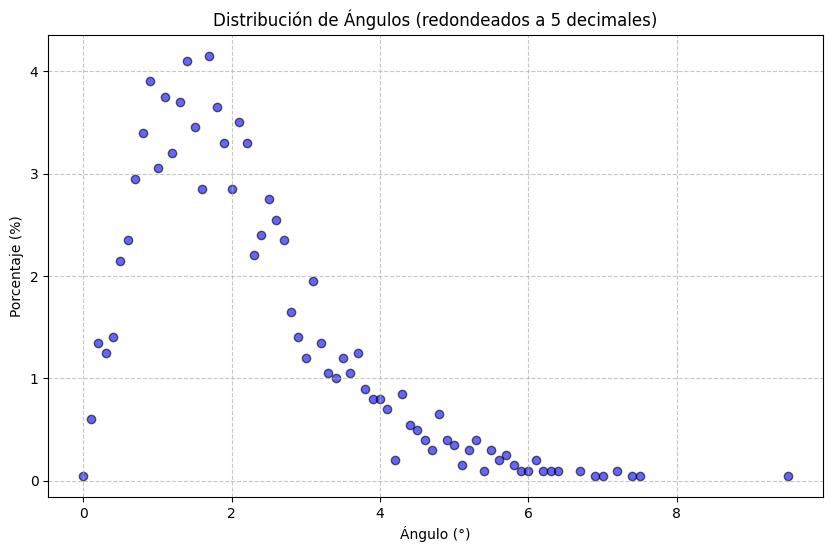

In [25]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

# Redondeamos los ángulos a 5 decimales
list_angle_redondeado = [round(angle, 1) for angle in list_angle]

# Contamos las repeticiones de cada ángulo redondeado
conteo_angulos = pd.Series(list_angle_redondeado).value_counts().sort_index()

# Calculamos el porcentaje de repeticiones
porcentaje_angulos = (conteo_angulos / len(list_angle_redondeado)) * 100

# Creamos el DataFrame con los ángulos redondeados y sus porcentajes
df = pd.DataFrame(
    {"Angulo": porcentaje_angulos.index, "Porcentaje": porcentaje_angulos.values}
)

# Creamos el scatter plot usando Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(df["Angulo"], df["Porcentaje"], color="blue", alpha=0.6, edgecolor="black")

# Etiquetas y título
plt.xlabel("Ángulo (°)")
plt.ylabel("Porcentaje (%)")
plt.title("Distribución de Ángulos (redondeados a 5 decimales)")

# Opcional: añadir líneas para visualizar mejor la distribución
plt.grid(True, linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

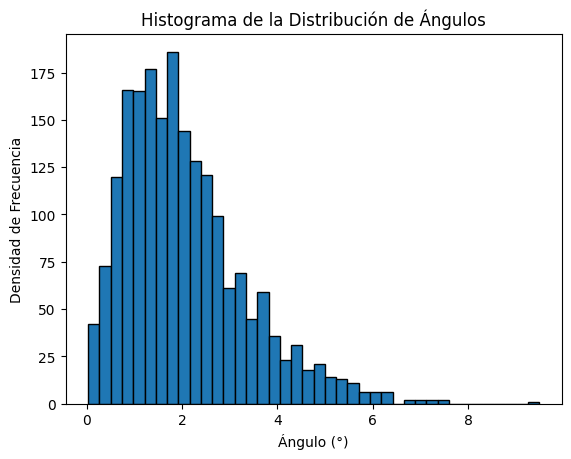

In [26]:
plt.hist(
    list_angle,
    bins=40,
    edgecolor="black",

)

# Etiquetas y título
plt.xlabel("Ángulo (°)")
plt.ylabel("Densidad de Frecuencia")
plt.title("Histograma de la Distribución de Ángulos")

# Mostrar el gráfico
plt.show()

In [28]:
def calcular_magnitud(vector):

    vector = np.array(vector)  
    magnitud = np.linalg.norm(vector)
    return magnitud

total = 0
targets_mag = []
predictions_mag = []

for i in range(len((prediction_all))):
    v = prediction_all[i]
    u = target_all[i]
    mag_u = calcular_magnitud(u)
    mag_v = calcular_magnitud(v)
    diff = mag_u - mag_v
    total += diff

    targets_mag.append(mag_u)
    predictions_mag.append(mag_v)

print(np.abs(total / len(prediction_all)))
print(
    "mean_absolute_error magnitud:", mean_absolute_error(targets_mag, predictions_mag)
)
print("mean squared error magnitud", jnp.mean((np.array(predictions_mag) - np.array(targets_mag)) ** 2))
print("RMSE magnitud ", root_mean_squared_error(targets_mag, predictions_mag))

0.003706005811691284
mean_absolute_error magnitud: 0.052623082
mean squared error magnitud 0.004853586
RMSE magnitud  0.06966768


In [104]:
import plotly.graph_objs as go
import plotly.io as pio
from typing import List

def create_loss_plot(
    train_loss: List[np.ndarray],
    val_loss: List[np.ndarray],
    train_label: str,
    val_label: str,
    title: str,
    filename: str,
) -> None:
    """
    Create a Plotly figure with training and validation loss curves and save it as an HTML file.

    Args:
        train_loss (List[np.ndarray]): List of training loss values.
        val_loss (List[np.ndarray]): List of validation loss values.
        train_label (str): Label for the training loss curve.
        val_label (str): Label for the validation loss curve.
        title (str): Title of the plot.
        filename (str): Filename to save the HTML file.

    Returns:
        None
    """
    train_loss_list = [float(loss) for loss in train_loss]
    val_loss_list = [float(loss) for loss in val_loss]

    trace_train = go.Scatter(y=train_loss_list, mode="lines", name=train_label)
    trace_val = go.Scatter(y=val_loss_list, mode="lines", name=val_label)

    fig = go.Figure()
    fig.add_trace(trace_train)
    fig.add_trace(trace_val)
    fig.update_layout(
        title=title, xaxis_title="Epoch", yaxis_title="Loss", legend_title="Legend"
    )
    pio.write_html(fig, filename)
    #fig.show()

create_loss_plot(
    list_train_loss,
    list_val_loss,
    "Training Loss",
    "Validation Loss",
    "Training vs Validation Loss (Train)",
    "train_vs_val_train_dipole_moment.html",
)

In [115]:
i = 45
Z, positions, target = valid_data['atomic_numbers'][i], valid_data['positions'][i], valid_data['dipole_moment'][i]
prediction = model.apply(params, Z, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))
print('positions \n', positions)

error_porcentual = abs(target - prediction) / abs(target) * 100
error_porcentual

In [106]:
error_porcentual = abs(target - prediction) / abs(target) * 100
error_porcentual

Array([4.852041 , 4.4297876, 3.4361415], dtype=float32)

In [209]:
i = 45
Z, positions, target = valid_data['atomic_numbers'][i], valid_data['positions'][i], valid_data['dipole_moment'][i]
positions -= positions[0, ...]
prediction = model.apply(params, Z, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))
#print('positions \n', positions)

target
[ 1.5010834  -0.35230795  1.6916788 ]
prediction
[-18.551952   -7.9866467  -3.266757 ]
mean squared error 161.66449


In [211]:
i = 45
Z, positions, target = valid_data['atomic_numbers'][i], valid_data['positions'][i], valid_data['dipole_moment'][i]
positions-=positions[0,...]
positions+=jnp.array([1000,1000,1000])
prediction = model.apply(params, Z, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))
#print('positions \n', positions)

target
[ 1.5010834  -0.35230795  1.6916788 ]
prediction
[-18.552917   -7.987112   -3.2702188]
mean squared error 161.69121


# MP Dipole Moment

In [ ]:
class MP_Dipole_Moment(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 118  # This is overkill for most applications.

    def dipole_moment(
        self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
    ):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff),
        )

        # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
        x = e3x.nn.Embed(
            num_embeddings=self.max_atomic_number + 1, features=self.features
        )(atomic_numbers)
        #print('Embed',x.shape)
        #print('Basis',basis.shape)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
                # features for efficiency reasons.
                y = e3x.nn.MessagePass(max_degree=2, include_pseudotensors=False)(
                    x, basis, dst_idx=dst_idx, src_idx=src_idx
                )
                #print('Final',y.shape)
                # After the final message pass, we can safely throw away all non-scalar features.
                x = e3x.nn.change_max_degree_or_type(
                    x, max_degree=2, include_pseudotensors=False
                )
            else:
                # In intermediate iterations, the message-pass should consider all possible coupling paths.
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
                #print('Message',y.shape)
            y = e3x.nn.add(x, y)

            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

            # Residual connection.
            x = e3x.nn.add(x, y)
            #print('Residual',x.shape)

        # 5. Predict atomic energies with an ordinary dense layer.
        #element_bias = self.param(
        #    "element_bias",
        #    lambda rng, shape: jnp.zeros(shape),
        #    (self.max_atomic_number + 1),
        #)
        x = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)  # (..., Natoms, 1, 9, 1)
        #print('After dense:',x.shape)
        x=jnp.sum(x, axis=-4) 
        #print("After sum:", x.shape)
        x = x[..., 1:4, 0]
        #print('After slicing:' ,x.shape)


        return x

    @nn.compact
    def __call__(
        self,
        atomic_numbers,
        positions,
        dst_idx,
        src_idx,
        batch_segments=None,
        batch_size=None,
    ):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
        # jax.value_and_grad to create a function for predicting both energy and forces for us.
        
        dipole = self.dipole_moment(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

        return dipole

In [ ]:
dm_model = MP_Dipole_Moment()
key = jax.random.PRNGKey(0)

# Generate train and test datasets.
key, data_key = jax.random.split(key)
num_train=10
num_val=2
train_data,valid_data=prepare_datasets(filename,key, num_train,num_val)
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(17)
params = dm_model.init(key,
    atomic_numbers=train_data['atomic_numbers'][0],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
moment = dm_model.apply(
            params,
            atomic_numbers=train_data["atomic_numbers"][0],
            positions=train_data["positions"][0],
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=None,
            batch_size=1,
        )
print(moment.shape)

Embed (17, 1, 1, 32)
Basis (272, 1, 9, 8)
Message (17, 1, 9, 32)
Residual (17, 1, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Final (17, 1, 9, 32)
Residual (17, 1, 9, 32)
After dense: (17, 1, 9, 1)
After sum: (1, 9, 1)
After slicing: (1, 3)
Embed (17, 1, 1, 32)
Basis (272, 1, 9, 8)
Message (17, 1, 9, 32)
Residual (17, 1, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Final (17, 1, 9, 32)
Residual (17, 1, 9, 32)
After dense: (17, 1, 9, 1)
After sum: (1, 9, 1)
After slicing: (1, 3)
(1, 3)


In [ ]:
def prepare_batches(key, data, batch_size):
    # Determine the number of training steps per epoch.
    data_size = len(data["dipole_moment"])
    steps_per_epoch = data_size // batch_size

    # Draw random permutations for fetching batches from the train data.
    perms = jax.random.permutation(key, data_size)
    perms = perms[
        : steps_per_epoch * batch_size
    ]  # Skip the last batch (if incomplete).
    perms = perms.reshape((steps_per_epoch, batch_size))

    # Prepare entries that are identical for each batch.
    num_atoms = len(data["atomic_numbers"])
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    atomic_numbers = jnp.tile(data["atomic_numbers"], batch_size)
    offsets = jnp.arange(batch_size) * num_atoms
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
    dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
    src_idx = (src_idx + offsets[:, None]).reshape(-1)

    # Assemble and return batches.
    return [
        dict(
            dipole_moment=data["dipole_moment"][perm].reshape(-1, 3),
            atomic_numbers=atomic_numbers,
            positions=data["positions"][perm].reshape(-1, 3),
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=batch_segments,
        )
        for perm in perms
    ]

In [ ]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, opt_state, params):
  def loss_fn(params):
    dipole = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      dipole_prediction=dipole,
      dipole_target=batch['dipole_moment']
    )
    return loss
  loss, grad = jax.value_and_grad(loss_fn)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, params):
  dipole = model_apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
  )
  loss = mean_squared_loss(
    energy_prediction=dipole,
    energy_target=batch['dipole_moment']
  )
  return loss


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers']))
  params = model.init(init_key,
    atomic_numbers=train_data['atomic_numbers'],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  opt_state = optimizer.init(params)

  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size)

    # Loop over train batches.
    train_loss = 0.0
    for i, batch in enumerate(train_batches):
      params, opt_state, loss= train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        opt_state=opt_state,
        params=params
      )
      train_loss += (loss - train_loss)/(i+1)

    # Evaluate on validation set.
    valid_loss = 0.0
    for i, batch in enumerate(valid_batches):
      loss = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)

    # Print progress.
    print(f"epoch: {epoch: 3d}                    train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3f} {valid_loss : 8.3f}")


  # Return final model parameters.
  return params